In [1]:
import numpy as np
try:  
    import cupy as xp  
    USE_GPU = True 
except ImportError:  
    import numpy as xp 
    print('No Cupy')
    USE_GPU = False 

import matplotlib.pyplot as plt
from tqdm import tqdm

# to mute the warnings of lal 
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

from Triangle.Constants import *
from Triangle.FFTTools import *
from Triangle.Noise import *
from Triangle.Orbit import *
from Triangle.Data import * 
from Triangle.GW import * 
from Triangle.TDI import * 

from gbgpu.gbgpu import GBGPU
from gbgpu.utils.constants import *
from gbgpu.utils.utility import *

# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'

# np.random.seed(114514)

No Cupy


PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1
/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/gbgpu/gbgpu.py:25: UserWarning: tdi module not found. No sensitivity information will be included.
  warnings.warn("tdi module not found. No sensitivity information will be included.")
/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/gbgpu/utils/utility.py:15: UserWarning: tdi module not found. No sensitivity information will be included.
  warnings.warn("tdi module not found. No sensitivity information will be included.")


## Initialize time-domain waveform simulation 

In [2]:
Tobs = YEAR 
dt = 10. 
tcb_times = np.arange(int(Tobs / dt)) * dt 
# Tobs = tcb_times[-1] 
Tobs = len(tcb_times) * dt 

# orbit model 
ORBIT_DIR = '../../Triangle-Simulator/OrbitData/MicroSateOrbitEclipticTCB'
orbit = Orbit(OrbitDir=ORBIT_DIR)

# generator for the unprojected waveforms
gb_waveform_generator = GB_Injection(use_gpu=False)

# # use TDI-A2, E2 channels 
# A2_string, E2_string, _ = TDIStringManipulation.AETStringsfromXString(GeneralTDIResponse.X2_strings)

# # initialize TDI response 
# A2_response_generator = GeneralTDIResponse(
#     orbit=orbit, 
#     Pstring=A2_string, 
#     tcb_times=xp.array(tcb_times), 
#     use_gpu=True, 
#     drop_points=int(1000/dt), # drop 100s at the beginning and end to avoid the invalid data caused by TDI calculation 
#     linear_interp=True, # should be enough for GBs 
#     )
# E2_response_generator = GeneralTDIResponse(
#     orbit=orbit, 
#     Pstring=E2_string, 
#     tcb_times=xp.array(tcb_times), 
#     use_gpu=True, 
#     drop_points=int(1000/dt), # drop 100s at the beginning and end to avoid the invalid data caused by TDI calculation 
#     linear_interp=True, # should be enough for GBs 
#     )

mich_response_generator = FastMichelsonTDIResponse(
    orbit=orbit, 
    tcb_times=tcb_times.copy(), 
    use_gpu=False, 
    drop_points=int(1000./dt), 
    interp_method="Spline3", 
)

## Initialize frequency-domain waveform 

In [3]:
Npoints = 512

gb = GBGPU(
    use_gpu=False, 
    orbit_file=ORBIT_DIR,
    unequal_arm=True,
    )

## Load population for test 

In [4]:
GB_catalogue = np.load("../Examples/BrightGBParams.npy")
GB_parameters = dict(
    A=GB_catalogue[:, 0], 
    f0=GB_catalogue[:, 1], 
    fdot0=GB_catalogue[:, 2], 
    inclination=GB_catalogue[:, 5], 
    phase0=GB_catalogue[:, 4], 
    longitude=GB_catalogue[:, 6], 
    latitude=GB_catalogue[:, 7], 
    psi=GB_catalogue[:, 8], 
)

## Compare single source 

In [5]:
# generate time-domain waveform 
test_GB_idx = 5
test_params = dict()
for k, v in GB_parameters.items(): 
    test_params[k] = v[test_GB_idx]

# test_td_waveform = np.array([
#     A2_response_generator(parameters=test_params, waveform_generator=gb_waveform_generator).get(), 
#     E2_response_generator(parameters=test_params, waveform_generator=gb_waveform_generator).get()
#     ]) # (2, Nt)
a_tmp, e_tmp, _ = mich_response_generator(parameters=test_params, waveform_generator=gb_waveform_generator, optimal_combination=True)
test_td_waveform = np.array([a_tmp, e_tmp])

test_params

{'A': 1.4322890827847326e-22,
 'f0': 0.0031041936685878187,
 'fdot0': 2.870129992903543e-16,
 'inclination': 0.9178066690061732,
 'phase0': 1.78040559431247,
 'longitude': 4.592239231398369,
 'latitude': -0.2777529084909986,
 'psi': 2.199327023733367}

In [6]:
# Fourier transform and select the frequency band of signal 
test_fd_waveform_from_td = [] 
for i in range(2):
    ff, xff = FFT_window(test_td_waveform[i], 1./dt) 
    test_fd_waveform_from_td.append(np.concatenate(([0.], xff))) # add a DC term to match the convension of xp.fft.rfft
test_fd_waveform_from_td = np.array(test_fd_waveform_from_td) # (2, Nf)
test_frequency = np.concatenate(([0.], ff))

fmin = test_params["f0"] - 1e-5
fmax = test_params["f0"] + 1e-5 
cutinds = np.where((test_frequency<=fmax)&(test_frequency>=fmin))[0]
test_fd_waveform_from_td = test_fd_waveform_from_td[:, cutinds]
test_frequency = test_frequency[cutinds]

test_frequency.shape, test_fd_waveform_from_td.shape 

((632,), (2, 632))

In [7]:
# generate frequency-domain waveform 
amp_in = np.atleast_1d(test_params["A"])
f0_in = np.atleast_1d(test_params["f0"])
fdot_in = np.atleast_1d(test_params["fdot0"])
fddot_in = 11.0 / 3.0 * fdot_in ** 2 / f0_in
phi0_in = np.atleast_1d(test_params["phase0"])
iota_in = np.atleast_1d(test_params["inclination"])
psi_in = np.atleast_1d(test_params["psi"])
lam_in = np.atleast_1d(test_params["longitude"])
beta_sky_in = np.atleast_1d(test_params["latitude"])
params = np.array(
    [amp_in, f0_in, fdot_in, fddot_in, phi0_in, iota_in, psi_in, lam_in, beta_sky_in,]
)
gb.run_wave(*params, N=Npoints, dt=dt, T=Tobs, oversample=4, tdi2=True)

# fill into a template that matches the shape of above time-domain calculation 
test_fd_waveform = xp.zeros((1, 2, len(cutinds)), dtype=xp.complex128)
gb.fill_global_template(group_index=np.array([0,]), templates=test_fd_waveform, A=gb.A, E=gb.E, start_inds=gb.start_inds, start_freq_ind=cutinds[0], N=Npoints)
test_fd_waveform = test_fd_waveform[0]

test_fd_waveform.shape 

(2, 632)

(3.1021936685878186, 3.1061936685878186)

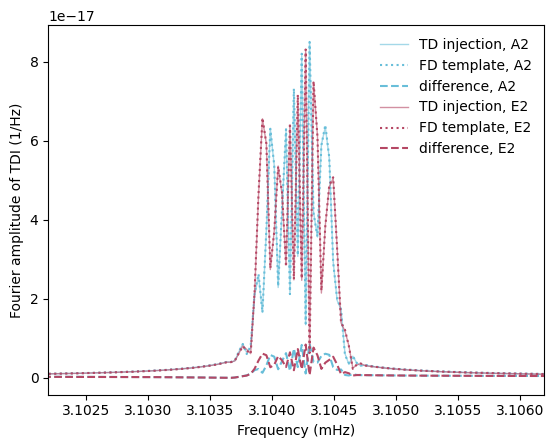

In [8]:
for ich, nch, colch in zip([0, 1], ["A2", "E2"], [BLUE, RED]):
    plt.plot(test_frequency * 1e3, np.abs(test_fd_waveform_from_td[ich]), label="TD injection, "+nch, color=colch, linewidth=1, alpha=0.6)
    plt.plot(test_frequency * 1e3, np.abs(test_fd_waveform[ich]), linestyle=":", label="FD template, "+nch, color=colch)
    plt.plot(test_frequency * 1e3, np.abs(test_fd_waveform_from_td[ich] - test_fd_waveform[ich]), label="difference, "+nch, color=colch, linestyle="--")
plt.legend(loc="upper right", frameon=False)
plt.xlabel("Frequency (mHz)")
plt.ylabel("Fourier amplitude of TDI (1/Hz)")
plt.xlim((test_params["f0"] - 2e-6)*1e3, (test_params["f0"] + 2e-6)*1e3)
# plt.savefig("../Figures/TD_vs_FD.jpg", dpi=300)

## Calculate mismatches across a group of bright sources
- optimize over initial phases 
- the source parameters are generated from DWD population model, and only those with SNR > 7 are selected. 

In [9]:
num_test_GBs = 200
min_MMs = [] 
min_phis = []
for test_GB_idx in tqdm(range(num_test_GBs)):
    test_params = dict()
    for k, v in GB_parameters.items(): 
        test_params[k] = v[test_GB_idx]
    
    # generate time-domain waveform 
    # test_td_waveform = np.array([
    #     A2_response_generator(parameters=test_params, waveform_generator=gb_waveform_generator).get(),
    #     E2_response_generator(parameters=test_params, waveform_generator=gb_waveform_generator).get()
    #     ])
    a_tmp, e_tmp, _ = mich_response_generator(parameters=test_params, waveform_generator=gb_waveform_generator, optimal_combination=True)
    test_td_waveform = np.array([a_tmp, e_tmp])

    # Fourier transform and select the frequency band of signal 
    test_fd_waveform_from_td = [] 
    for i in range(2):
        ff, xff = FFT_window(test_td_waveform[i], 1./dt) 
        test_fd_waveform_from_td.append(np.concatenate(([0.], xff))) # add a DC term to match the convension of xp.fft.rfft
    test_fd_waveform_from_td = np.array(test_fd_waveform_from_td)
    test_frequency = np.concatenate(([0.], ff))

    fmin = test_params["f0"] - 1e-5
    fmax = test_params["f0"] + 1e-5 
    cutinds = np.where((test_frequency<=fmax)&(test_frequency>=fmin))[0]
    test_fd_waveform_from_td = test_fd_waveform_from_td[:, cutinds]
    test_frequency = test_frequency[cutinds]

    num_bin = 100 
    amp_in = np.ones(num_bin) * test_params["A"]
    f0_in = np.ones(num_bin) * test_params["f0"]
    fdot_in = np.ones(num_bin) * test_params["fdot0"]
    fddot_in = 11.0 / 3.0 * fdot_in ** 2 / f0_in
    phi0_in = np.linspace(0, TWOPI, num_bin) # 0 to 2pi 
    iota_in = np.ones(num_bin) * test_params["inclination"]
    psi_in = np.ones(num_bin) * test_params["psi"]
    lam_in = np.ones(num_bin) * test_params["longitude"]
    beta_sky_in = np.ones(num_bin) * test_params["latitude"]
    params = np.array(
        [amp_in, f0_in, fdot_in, fddot_in, phi0_in, iota_in, psi_in, lam_in, beta_sky_in,]
    )
    gb.run_wave(*params, N=Npoints, dt=dt, T=Tobs, oversample=4, tdi2=True)

    # fill into a template that matches the shape of above time-domain calculation 
    test_fd_waveform = xp.zeros((num_bin, 2, len(cutinds)), dtype=xp.complex128)
    gb.fill_global_template(group_index=np.arange(num_bin), templates=test_fd_waveform, A=gb.A, E=gb.E, start_inds=gb.start_inds, start_freq_ind=cutinds[0], N=Npoints)
    test_fd_waveform = test_fd_waveform
    
    # calculate misatches (the PSD is nearly flat around f0)
    h1_h2_inner = np.real(np.sum(test_fd_waveform_from_td * np.conjugate(test_fd_waveform), axis=(1, 2))) # (num_bin)
    h1_inner = np.sum(np.abs(test_fd_waveform_from_td) ** 2) # scalar  
    h2_inner = np.sum(np.abs(test_fd_waveform) ** 2, axis=(1, 2)) # (num_bin,)
    MMs = 1. - h1_h2_inner / np.sqrt(h1_inner * h2_inner) # (num_bin,)
    min_MMs.append(np.min(MMs))
    min_phis.append(phi0_in[np.argmin(MMs)])
    

100%|██████████| 200/200 [28:07<00:00,  8.44s/it]


In [10]:
min_MMs = np.array(min_MMs)
min_phis = np.array(min_phis)

Text(0, 0.5, 'PDF')

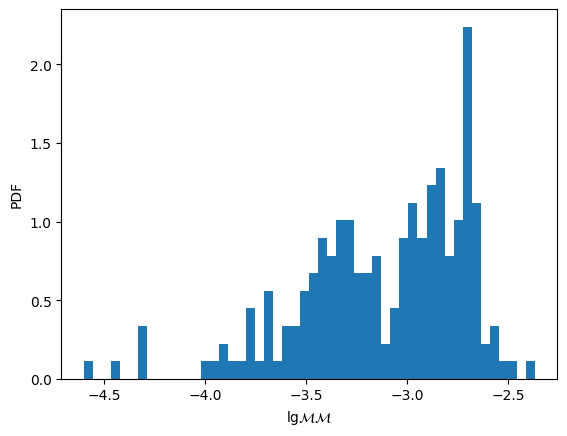

In [11]:
plt.hist(np.log10(min_MMs), bins=50, density=True);
plt.xlabel(r'$\mathrm{lg}\mathcal{MM}$')
plt.ylabel('PDF')

``FastGB`` may not be a good approximation at $f_0 > 10$ mHz, while for $f_0 < 10$ mHz it matches rigorous time-domain injection with $\mathcal{MM} < 10^{-2}$. 

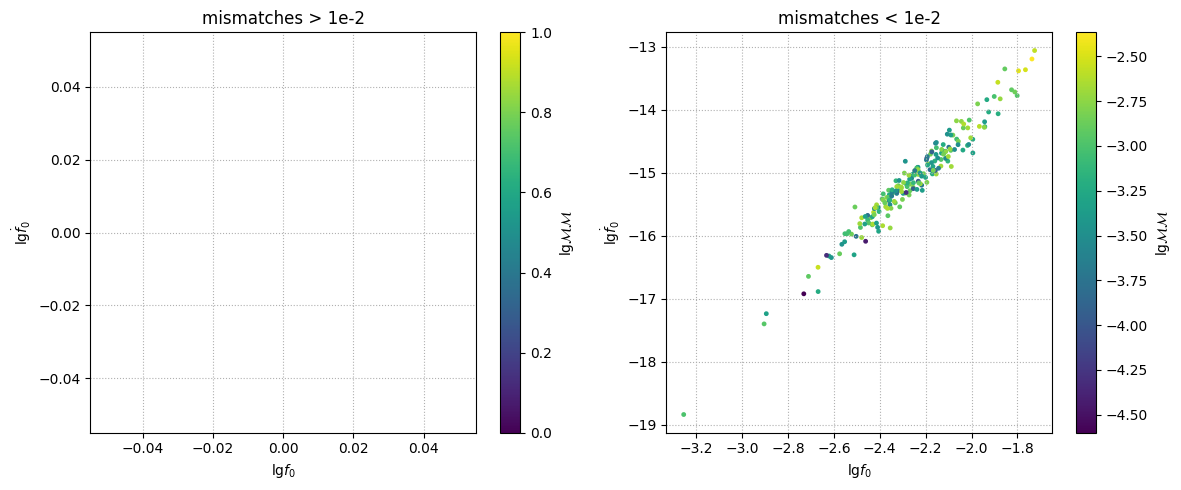

In [12]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
source_idx = np.where(min_MMs > 1e-2)[0]
sc = plt.scatter(np.log10(GB_parameters["f0"][:num_test_GBs][source_idx]), np.log10(GB_parameters["fdot0"][:num_test_GBs][source_idx]), c=np.log10(min_MMs[source_idx]), cmap='viridis', edgecolor='none', s=12)
cbar = plt.colorbar(sc)
cbar.set_label(r'$\mathrm{lg}\mathcal{MM}$')
plt.xlabel(r'$\mathrm{lg}f_0$')
plt.ylabel(r'$\mathrm{lg}\dot{f}_0$')
plt.grid(linestyle=":")
plt.title("mismatches > 1e-2")

plt.subplot(122)
source_idx = np.where(min_MMs < 1e-2)[0]
sc = plt.scatter(np.log10(GB_parameters["f0"][:num_test_GBs][source_idx]), np.log10(GB_parameters["fdot0"][:num_test_GBs][source_idx]), c=np.log10(min_MMs[source_idx]), cmap='viridis', edgecolor='none', s=12)
cbar = plt.colorbar(sc)
cbar.set_label(r'$\mathrm{lg}\mathcal{MM}$')
plt.xlabel(r'$\mathrm{lg}f_0$')
plt.ylabel(r'$\mathrm{lg}\dot{f}_0$')
plt.grid(linestyle=":")
plt.title("mismatches < 1e-2")

plt.tight_layout()

Text(0, 0.5, 'PDF')

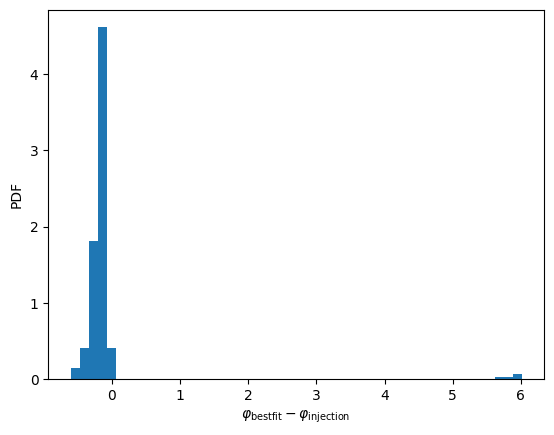

In [13]:
plt.hist(np.array(min_phis) - GB_parameters["phase0"][:num_test_GBs], bins=50, density=True);
plt.xlabel(r'$\varphi_{\rm bestfit} - \varphi_{\rm injection}$')
plt.ylabel('PDF')